# Dataset

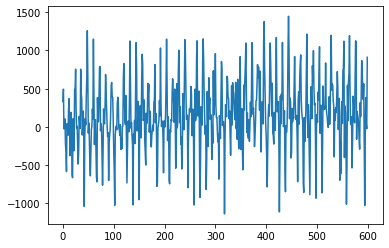

In [1]:
from hana_ml import dataframe
import json
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from data_load_utils import DataSets, Settings
import plotting_utils
url, port, user, pwd = Settings.load_config("../../config/e2edata.ini")
conn = dataframe.ConnectionContext(url, port, user, pwd)

from scipy.stats import norm
from scipy.linalg import cholesky
import numpy as np
from numpy.random import rand

num_samples = 600
S1 = 12
S2 = 100

np.random.seed(seed=2334)

x1 = norm.rvs(loc=0, scale=1, size=(1, num_samples))[0]
x2 = norm.rvs(loc=0, scale=1, size=(1, num_samples))[0]
x3 = norm.rvs(loc=0, scale=1, size=(1, num_samples))[0]
x4 = norm.rvs(loc=0, scale=1, size=(1, num_samples))[0]

std_m = np.array([
    [6.8, 0, 0, 0],
    [0, 1.4, 0, 0],
    [0, 0, 1.4, 0],
    [0, 0, 0, 2.9]
])

# specify desired correlation
corr_m = np.array([
    [1, .35, 0.33, 0.78],
    [.35, 1, 0.90, 0.28],
    [.33, 0.90, 1, 0.27],
    [.78, 0.28, 0.27, 1]
])

# calc desired covariance (vc matrix)
cov_m = np.dot(std_m, np.dot(corr_m, std_m))
L = cholesky(cov_m, lower=True)
corr_data = np.dot(L, [x1, x2, x3, x4]).T

beta=np.array([-3.49, 13, 13, 0.0056])
omega1 = 2*np.pi/S1
omega2 = 2*np.pi/S2
timestamp = np.array([i for i in range(num_samples)])
y1 = np.multiply(50*rand(num_samples), 20*rand(1)*np.cos(omega1*timestamp)) \
+ np.multiply(32*rand(num_samples), 30*rand(1)*np.cos(3*omega1*timestamp)) \
+ np.multiply(rand(num_samples), rand(1)*np.sin(omega2*timestamp)) 

y2 = np.multiply(rand(num_samples), timestamp)

y3 = corr_data.dot(beta.T)

y = y1 + y2 + y3

plt.plot(y)


### ARIMA Expaliner

In [2]:
timestamp = [i for i in range(len(y))]
raw = {'ID':timestamp, 'Y':y, 'X1':corr_data[:,0], 'X2':corr_data[:,1], 'X3':corr_data[:,2], 'X4':corr_data[:,3]}
rdata = pd.DataFrame(raw)
cutoff = (int)(rdata.shape[0]*0.9)
#print(len(rdata.iloc[:cutoff:,:]))
df_fit = dataframe.create_dataframe_from_pandas(conn, rdata.iloc[:cutoff,:], table_name='PAL_ARIMA_FIT_TBL', force=True)
print(df_fit.head(5).collect())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.03it/s]


   ID           Y         X1        X2        X3        X4
0   0  332.758593   3.745440  0.277129  0.386102  4.677009
1   1  493.354326 -11.276675 -1.531452 -1.960284  0.572942
2   2  -24.637460   6.038712  0.993921  0.861950  1.695091
3   3  -17.499518  -2.253259 -1.238754 -0.867938 -4.445587
4   4  105.053023   8.495006  2.117950  2.570215  0.190207


In [3]:
from hana_ml.algorithms.pal.tsa.arima import ARIMA
from hana_ml.algorithms.pal.tsa.auto_arima import AutoARIMA
tic = time.perf_counter()
arima= AutoARIMA(background_size=-1)
arima.fit(df_fit, key='ID', endog='Y', exog=['X1', 'X2', 'X3', 'X4'])
toc = time.perf_counter()
print('time is %.4f s' % (toc-tic))
print(arima.fitted_.collect())
print(arima.model_.collect())

time is 16.6200 s
      ID      FITTED   RESIDUALS
0      0         NaN         NaN
1      1  292.905985  200.448342
2      2  458.818902 -483.456362
3      3  376.050016 -393.549534
4      4  361.697191 -256.644168
..   ...         ...         ...
535  535   24.829740  201.677394
536  536  470.313103 -384.776202
537  537   69.068312  180.916556
538  538  352.773169 -162.753134
539  539  389.189346   35.041416

[540 rows x 3 columns]
                     KEY                                              VALUE
0                      p                                                  2
1                     AR                                   0.181919;0.10149
2                      d                                                  1
3                      q                                                  1
4                     MA                                           -0.99442
5                      s                                                 12
6                      P      

In [4]:
#print(len(rdata.iloc[cutoff:,:]))
df_predict = dataframe.create_dataframe_from_pandas(conn, rdata.iloc[cutoff:,:], table_name='PAL_ARIMA_PREDICT_TBL', force=True)
#print(df_predict.head(5).collect())
tic = time.perf_counter()
res = arima.predict(df_predict, top_k_attributions=30, seasonal_width=0.035, trend_width=0.035, show_explainer=True)
toc = time.perf_counter()
print('time is %.4f s' % (toc-tic))
print(res.head(5).collect())
print(arima.explainer_.head(5).collect())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.68it/s]


time is 2.6604 s
   ID    FORECAST          SE        LO80         HI80        LO95  \
0   0  697.904036  275.830020  344.413522  1051.394549  157.287126   
1   1  566.330681  280.636662  206.680205   925.981157   16.292925   
2   2  410.378309  283.325578   47.281848   773.474770 -144.929624   
3   3  325.120406  283.664980  -38.411016   688.651828 -230.852742   
4   4  295.415846  283.778188  -68.260658   659.092350 -260.779185   

          HI95  
0  1238.520945  
1  1116.368436  
2   965.686241  
3   881.093554  
4   851.610878  
   ID       TREND    SEASONAL TRANSITORY  IRREGULAR  \
0   0  200.302480  497.987373       None  -0.434860   
1   1  349.170747  212.832526       None   4.278373   
2   2  270.882280  137.071172       None   2.375824   
3   3  247.572342   92.836809       None -15.337771   
4   4  302.237669  -23.708162       None  16.837314   

                                           EXOGENOUS  
0  [{"attr":"X3","val":10.996544195511439,"pct":4...  
1  [{"attr":"X2","v

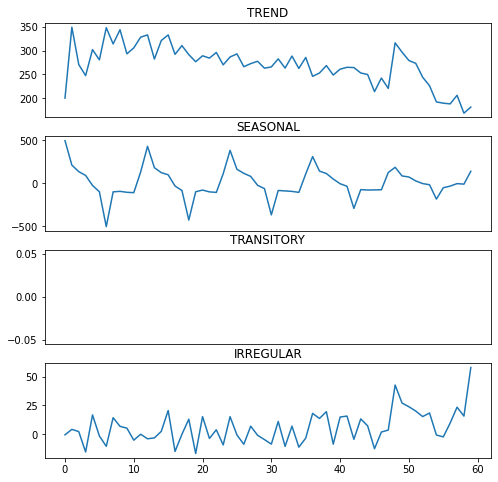

In [5]:
def plotComp(explainer, s = 0, ranges=[]):
    name = ["TREND","SEASONAL","TRANSITORY","IRREGULAR"]
    plt.figure(figsize=(8,8))
    for i in range(1, 5, 1):
        plt.subplot(4,1,i)
        plt.plot(explainer.iloc[:,i].to_numpy())
        ax = plt.gca()
        if i == 1 and s > 1:            
            for j in range(explainer.shape[0] // s):                
                ax.axvline(x=(j+1)*s, color='red', ls='--')
        plt.title(name[i-1])
        if i != 4:
            ax.get_xaxis().set_visible(False)

plotComp(arima.explainer_.collect())

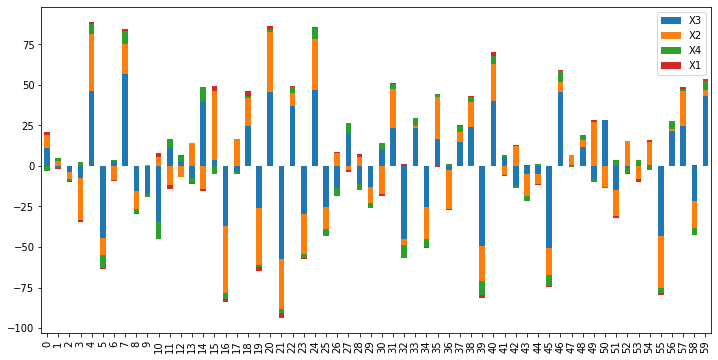

In [6]:
def readRScode(explainer):
    dicts = {}
    for j in range(explainer.shape[0]):
        if len(explainer["EXOGENOUS"].values[j]) == 0:
            return dicts
        fattr = json.loads(explainer["EXOGENOUS"].values[j])
        for i in range(len(fattr)):
            if(fattr[i]['attr'] in dicts):
                dicts[fattr[i]['attr']].append(fattr[i]['val'])
            else:
                dicts[fattr[i]['attr']] = [fattr[i]['val']]
    return dicts

def plotExt(explainer):
    dicts = readRScode(explainer)
    if len(dicts) == 0:
        return    
    ax = pd.DataFrame(dicts).plot(figsize=(12,6), kind='bar', stacked=True)
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.plot()

plotExt(arima.explainer_.collect())

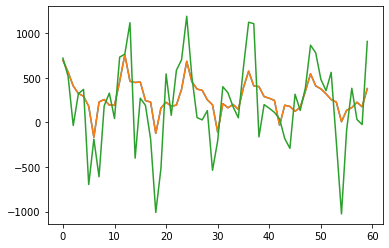

In [7]:
decompose_result = arima.explainer_.collect() 
#print(decompose_result)
plt.plot(decompose_result['TREND']+decompose_result["SEASONAL"]+decompose_result["IRREGULAR"])
plt.plot(res.collect()['FORECAST'])
plt.plot(df_predict.collect()['Y'])

### Additive Model Forecast Explainer

In [8]:
from hana_ml.algorithms.pal.tsa import additive_model_forecast

dates = pd.date_range('2018-01-01', '2019-08-23',freq='D')
data_additive = {'ID':dates, 'Y':y, 'X1':corr_data[:,0], 'X2':corr_data[:,1], 'X3':corr_data[:,2], 'X4':corr_data[:,3]}
data = pd.DataFrame(data_additive)
cutoff = (int)(data.shape[0]*0.9)
print(len(data.iloc[:cutoff:,:]))
df_fit_additive = dataframe.create_dataframe_from_pandas(conn, data.iloc[:cutoff,:], table_name='PAL_ADDITIVE_FIT_TBL', force=True)
print(df_fit_additive.head(5).collect())
print(len(data.iloc[cutoff:,:]))
df_predict_additive= dataframe.create_dataframe_from_pandas(conn, data.iloc[cutoff:,:], table_name='PAL_ADDITIVE_PREDICT_TBL', force=True)
print(df_predict_additive.head(5).collect())

540


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.22s/it]


          ID           Y         X1        X2        X3        X4
0 2018-01-01  332.758593   3.745440  0.277129  0.386102  4.677009
1 2018-01-02  493.354326 -11.276675 -1.531452 -1.960284  0.572942
2 2018-01-03  -24.637460   6.038712  0.993921  0.861950  1.695091
3 2018-01-04  -17.499518  -2.253259 -1.238754 -0.867938 -4.445587
4 2018-01-05  105.053023   8.495006  2.117950  2.570215  0.190207
60


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.75it/s]


          ID           Y         X1        X2        X3        X4
0 2019-06-25  722.628192  -6.526262  0.424765  0.629801  1.384716
1 2019-06-26  519.094398 -10.829483  0.536936  0.357496 -2.466243
2 2019-06-27  -33.680580  -1.970426  0.648036  0.379930  0.219694
3 2019-06-28  323.132899  -5.052546 -2.334643 -2.370179 -2.582126
4 2019-06-29  371.678377  -7.517102  0.523558  1.146610 -5.501772


In [9]:
holiday_dic={"Date":['2018-01-01','2018-01-04','2018-01-05','2019-06-25','2019-06-29'],
             "Name":['A', 'A', 'B', 'A', 'D']}
df=pd.DataFrame(holiday_dic)
df_holiday= dataframe.create_dataframe_from_pandas(conn, df, table_name='PAL_HOLIDAY_TBL', force=True)
df_holiday=df_holiday.cast('Date', 'TIMESTAMP')
#print(df_holiday.dtypes())

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.76it/s]


In [22]:
amf = additive_model_forecast.AdditiveModelForecast(growth='linear',
                                                    regressor = ['{"NAME": "X1", "PRIOR_SCALE":4, "MODE": "additive" }'],
                                                    seasonality=['{ "NAME": "yearly", "PERIOD":365.25, "FOURIER_ORDER":10 }',
                                                                 '{ "NAME": "weekly", "PERIOD":7, "FOURIER_ORDER":3 }',
                                                                 '{ "NAME": "daily", "PERIOD":1, "FOURIER_ORDER":4 }'])

#amf = additive_model_forecast.AdditiveModelForecast(growth='linear',
#                                                    regressor = ['{"NAME": "X1", "PRIOR_SCALE":4, "MODE": "multiplicative"}',
#                                                                 '{"NAME": "X2", "PRIOR_SCALE":4, "MODE": "multiplicative"}'],
#                                                    seasonality=['{ "NAME": "yearly", "PERIOD":365.25, "FOURIER_ORDER":10 }',
#                                                                 '{ "NAME": "weekly", "PERIOD":7, "FOURIER_ORDER":3 }',
#                                                                 '{ "NAME": "daily", "PERIOD":1, "FOURIER_ORDER":4 }'])
amf.fit(df_fit_additive, key='ID', endog='Y', exog=['X1','X2','X3','X4'], holiday=df_holiday)
model_content = amf.model_.collect()['MODEL_CONTENT']

In [23]:
#MODEL_CONTENT
#"regressor_mode":[[1,0,0,0]], 1 is multiplicative, 0 is additive.
#{"GROWTH":"linear","FLOOR":0.0,"SEASONALITY_MODE":"additive","start":"2018-01-01 00:00:00.0000000","y_scale":1446.4012732304484,"t_scale":46569600.0,"cat_field_moments":"","regressor_name":[["X1","X2","X3","X4"]],"regressor_mu":[[-0.15352821733097303,-0.02059063426228545,-0.002622304887415057,-0.10345704770210677]],"regressor_std":[[6.791693022193103,1.3353406148220398,1.3372264170094813,2.9259028871764767]],"regressor_mode":[[1,0,0,0]],"regressor_prior_scale":[[4.0,10.0,10.0,10.0]],"seasonality_name":[["DAILY","weekly"]],"seasonality_period":[[30.0,7.0]],"seasonality_fourier_order":[[10.0,3.0]],"seasonality_prior_scale":[[10.0,10.0]],"seasonality_mode":[[0,0]],"holiday_name":[["A","A","B","A","D"]],"holiday_ts":[["2018-01-01 00:00:00.0000000","2018-01-04 00:00:00.0000000","2018-01-05 00:00:00.0000000","2019-06-25 00:00:00.0000000","2019-06-29 00:00:00.0000000"]],"holiday_lw":[[0,0,0,0,0]],"holiday_uw":[[0,0,0,0,0]],"k":0.15606952574757727,"m":0.025836199662412366,"delta":[[-6.292126065062676e-9,4.01672269727309e-9,2.1199765509020952e-10,1.1932762503249709e-8,-1.047803486376465e-9,1.8065798418999697e-9,-2.8338697798904576e-9,2.2734610420403154e-9,-9.36221620884908e-10,-3.096382176225027e-10,5.653371984077469e-10,0.000031771424734759676,-1.5103667461775418e-9,-6.952915812686268e-10,5.433302104204915e-10,1.4341194324681475e-8,-3.574888497386598e-9,-9.234203104205178e-9,1.4041591463701508e-9,-4.00089518484598e-10,8.627030356665826e-10,-9.464287117143478e-10,4.888208823553357e-9,3.401487456236214e-9,-4.233127346960964e-9]],"sigma_obs":0.29438644660697607,"beta":[[0.015268230138996909,-0.003723949172106288,-0.0012454511299372015,-0.014667147419791627,-0.002224602367867149,-0.011283684269001934,-0.007317937252829013,-0.0004909591674430246,0.015828377538860389,0.010889381438311124,0.013112690781791187,0.004675841012075908,-0.004266746836168113,-0.004887592550691263,-0.007487924296738099,-0.015804821532827714,-0.004811506922077433,0.0014824729740768239,0.001687420100693144,-0.022634540897335136,0.005235189349347453,0.010465205938117489,0.001449572788947729,-0.017951886315960669,0.009509697995534044,0.006325292067880513,0.01758779609226314,-0.003368025414656735,0.0,0.03176160107239431,-0.019135738672922624,0.041173876634595849,-0.01850148374778878]],"changepoints_t":[[0.03153988868274583,0.06307977736549166,0.09647495361781076,0.1280148423005566,0.15955473098330243,0.19109461966604825,0.22448979591836736,0.2560296846011132,0.287569573283859,0.31910946196660486,0.3525046382189239,0.38404452690166976,0.4155844155844156,0.44712430426716145,0.4805194805194805,0.5120593692022264,0.5435992578849722,0.575139146567718,0.608534322820037,0.640074211502783,0.6716141001855288,0.7031539888682746,0.7365491651205937,0.7680890538033395,0.7996289424860853]],"holidays_prior_scale":10.0}

In [24]:
#t= dataframe.create_dataframe_from_pandas(conn, amf.model_.collect(), table_name='AAAA', force=True)

In [25]:
res = amf.predict(data=df_predict_additive, key= 'ID', show_explainer=True, decompose_seasonality=True, decompose_holiday=True)
print(res.head(5).collect())
print(amf.explainer_.head(5).collect())
print(amf.explainer_.head(15).collect()['SEASONAL'])
print(amf.explainer_.head(5).collect()['EXOGENOUS'][0])

          ID        YHAT  YHAT_LOWER  YHAT_UPPER
0 2019-06-25  266.229082 -281.123018  815.359239
1 2019-06-26  223.114672 -334.597240  814.240422
2 2019-06-27  206.465628 -322.795491  774.999535
3 2019-06-28  189.704328 -368.993402  719.605580
4 2019-06-29  303.910378 -272.248186  844.867330
          ID       TREND                                           SEASONAL  \
0 2019-06-25  507.283607  {"daily":-240.39364822704679,"weekly":29.89130...   
1 2019-06-26  507.718284  {"daily":-240.39364822704679,"weekly":-6.76211...   
2 2019-06-27  508.152960  {"daily":-240.39364822704679,"weekly":-1.82723...   
3 2019-06-28  508.587637  {"daily":-240.39364822704679,"weekly":19.80222...   
4 2019-06-29  509.022313  {"daily":-240.39364822704679,"weekly":21.15075...   

                                             HOLIDAY  \
0  {"A":16.808087537203,"A":16.808087537203,"A":1...   
1          {"A":0.0,"A":0.0,"A":0.0,"B":0.0,"D":0.0}   
2          {"A":0.0,"A":0.0,"A":0.0,"B":0.0,"D":0.0}   
3      

In [26]:
res = amf.predict(data=df_predict_additive, show_explainer=True, decompose_seasonality=False, decompose_holiday=False)
print(res.head(10).collect())
print(amf.explainer_.head(10).collect())

          ID        YHAT  YHAT_LOWER  YHAT_UPPER
0 2019-06-25  266.229082 -281.123018  815.359239
1 2019-06-26  223.114672 -334.597240  814.240422
2 2019-06-27  206.465628 -322.795491  774.999535
3 2019-06-28  189.704328 -368.993402  719.605580
4 2019-06-29  303.910378 -272.248186  844.867330
5 2019-06-30  177.002389 -371.429261  742.205119
6 2019-07-01  136.306250 -436.458135  689.881624
7 2019-07-02  311.197629 -246.538043  838.860377
8 2019-07-03  234.415083 -302.155658  790.330942
9 2019-07-04  226.755733 -324.875402  771.336229
          ID       TREND                               SEASONAL  \
0 2019-06-25  507.283607  {"seasonalities":-251.89379192399069}   
1 2019-06-26  507.718284  {"seasonalities":-296.37073103039327}   
2 2019-06-27  508.152960  {"seasonalities":-298.35143614491798}   
3 2019-06-28  508.587637   {"seasonalities":-282.6154799242014}   
4 2019-06-29  509.022313  {"seasonalities":-286.05345854136717}   
5 2019-06-30  509.456989  {"seasonalities":-327.06043767656

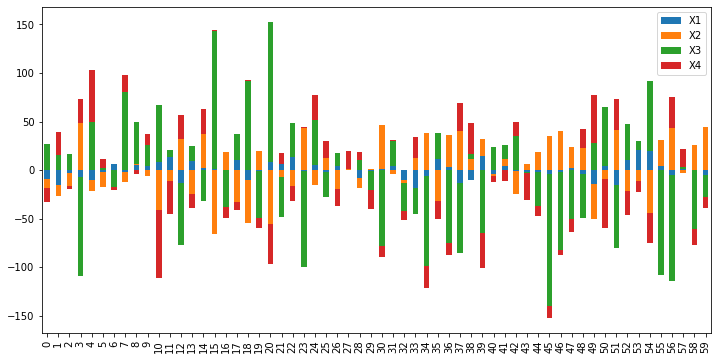

In [27]:
explainer= amf.explainer_.collect()
def readExog(explainer):
    dicts = {}
    for j in range(explainer.shape[0]):
        if len(explainer["EXOGENOUS"].values[j]) == 2:
            return dicts
        exog = json.loads(explainer["EXOGENOUS"].values[j])
        if j == 0:
            dicts['X1']= [exog['X1']]
            dicts['X2']= [exog['X2']]
            dicts['X3']= [exog['X3']]
            dicts['X4']= [exog['X4']]
        else:
            dicts['X1'].append(exog['X1']) 
            dicts['X2'].append(exog['X2']) 
            dicts['X3'].append(exog['X3']) 
            dicts['X4'].append(exog['X4']) 
    return dicts

def plotExt(explainer):
    dicts = readExog(explainer)
    if len(dicts) == 0:
        return
    #print(dicts)
    ax = pd.DataFrame(dicts).plot(figsize=(12,6), kind='bar', stacked=True)
    ax.legend(bbox_to_anchor=(1.0, 1.0))
    ax.plot()

plotExt(explainer)